In [215]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

In [145]:
input_path = "../../MITgcm/experiments/rotated_BBTRE_rest-tracer/input/"

## Physical parameters

In [146]:
# environmental parameters
N = 1.3e-3
f = -0.53e-4

gravity = 9.81
tAlpha = 2.e-4

# grid param
nx = 800
ny = 120
nz = 260

dx = 500 
dy = 500
dz0 = 5
nz_vary_frac = 0.62

Lx = nx*dx
Ly = ny*dy
print(f"Lx = {Lx*1e-3}, Ly = {Ly*1e-3}")

# topographic parameters
slopeAngle = 2.e-3

# mixing parameters
d = 230
k0 = 5.2e-5
k1 = 1.8e-3

Lx = 400.0, Ly = 60.0


## BBTRE Topography

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 450)
Coordinates:
  * lon      (lon) float64 -18.99 -18.97 -18.96 -18.94 ... -11.54 -11.53 -11.51
  * lat      (lat) float64 -21.99 -21.98 -21.96 -21.94 ... -20.04 -20.02 -20.01
    X        (lon) float64 0.0 1.727e+03 3.454e+03 ... 7.736e+05 7.753e+05
    Y        (lat) float64 0.0 1.853e+03 3.706e+03 ... 2.187e+05 2.205e+05
Data variables:
    z        (lat, lon) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        
    history:      grdsample -R-180/180/-80/80 -I1m @GMTAPI@-000001 -Gtopo_19....
    description:  
    GMT_version:  5.4.5 [64-bit]
    node_offset:  1

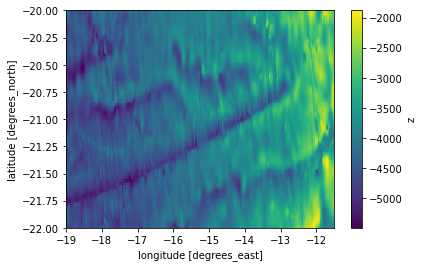

In [147]:
ds = xr.open_dataset("../../data/SS97_topography.nc")
ds = ds.sel(lon=slice(-19,-11.5), lat=slice(-22.,-20.))

R = 6.371e6
circ = 2.*np.pi*R

ds = ds.assign_coords({
    'X': (ds['lon'] - ds['lon'].isel(lon=0)) * circ/360. * np.cos(np.deg2rad(ds['lat'].sel(lat=-21.3, method='nearest'))),
    'Y': (ds['lat'] - ds['lat'].isel(lat=0)) * circ/360.
})
ds['z'].plot()
ds.to_netcdf(input_path+"geocoords_original.nc")


ds

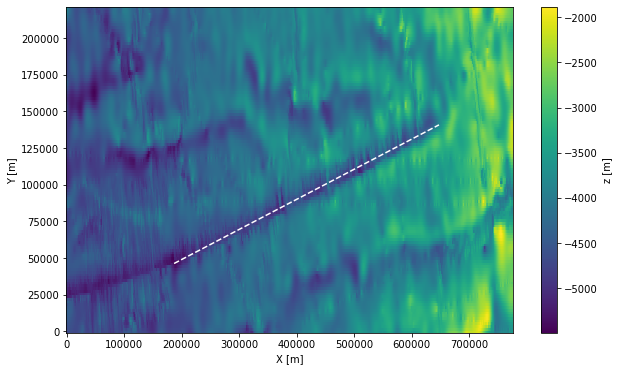

In [148]:
plt.figure(figsize=(10,6))
lats_deg = [-21.575, -20.725]; lons_deg = [-17.2, -12.75]
lats_dist = ds['Y'].sel(lat=lats_deg, method='nearest')
lons_dist = ds['X'].sel(lon=lons_deg, method='nearest')

q = ds['z'].plot(x='X', y='Y')
q.colorbar.set_label('z [m]')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.plot(lons_dist, lats_dist, 'w--')

#plt.savefig("../../figures/BBTRE/config_canyon.png", dpi=100., bbox_inches='tight')

#### Rotate into along-canyon and cross-canyon coordinates

In [149]:
canyon_angle = np.arctan(np.diff(lats_dist)/np.diff(lons_dist))

In [150]:
Xr_1d = np.arange(0., Lx, dx)[np.newaxis,:]
Yr_1d = np.arange(0., Ly, dy)[:,np.newaxis]

#### Interpolate onto subdomain with new rotated coordinate frame

In [151]:
X = xr.DataArray(
    data = Xr_1d*np.cos(canyon_angle) - Yr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)
Y = xr.DataArray(
    data = Yr_1d*np.cos(canyon_angle) + Xr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)

<xarray.Dataset>
Dimensions:  (Xr: 800, Yr: 120)
Coordinates:
    lon      (Yr, Xr) float64 -17.19 -17.19 -17.18 ... -13.54 -13.53 -13.53
    lat      (Yr, Xr) float64 -21.84 -21.84 -21.84 -21.84 ... -20.6 -20.6 -20.6
    X        float64 1.865e+05
    Y        float64 4.633e+04
  * Yr       (Yr) float64 0.0 500.0 1e+03 1.5e+03 ... 5.85e+04 5.9e+04 5.95e+04
  * Xr       (Xr) float64 0.0 500.0 1e+03 ... 3.985e+05 3.99e+05 3.995e+05
Data variables:
    z        (Yr, Xr) float64 -4.5e+03 -4.505e+03 ... -3.143e+03 -3.156e+03

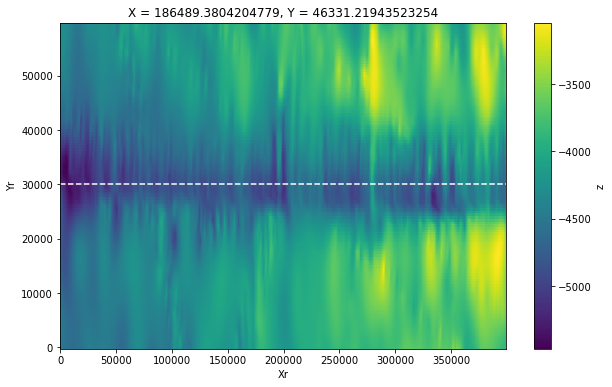

In [152]:
newds = xr.Dataset()
newds['z'] = (
    ds['z']
    .swap_dims({'lon':'X', 'lat':'Y'})
    .interp(X=X+lons_dist[0], Y=Y+lats_dist[0]-Ly/2)
)

plt.figure(figsize=(10,6))
newds['z'].plot()
plt.plot(newds['Xr'], 0.*newds['Xr'] + Ly/2, "w--")
newds

#plt.savefig("../../figures/BBTRE/config_canyon_canyon-axis-coords.png", dpi=100., bbox_inches='tight')

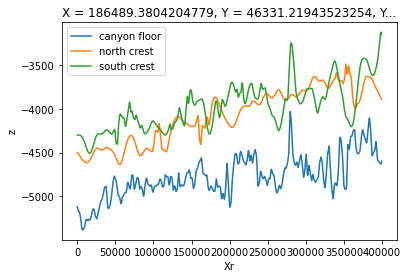

In [153]:
newds['z'].sel(Yr=3e4, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=0).plot(label='north crest')
newds['z'].isel(Yr=-1).plot(label='south crest')
plt.legend()
#plt.savefig("../../figures/BBTRE/config_canyon_along-channel-section.png", dpi=100., bbox_inches='tight')

#### Remove (and record) mean slope of canyon

In [154]:
slopeAngle, b = np.polyfit(newds['Xr'], newds['z'].sel(Yr=3e4, method='nearest'), deg=1)
print(f"θ = {slopeAngle}")

newds['z_slope'] = slopeAngle * newds['Xr'] + b

newds['z_with_slope'] = newds['z'].copy()
newds['z'] = newds['z'] - newds['z_slope']

θ = 0.0015258037215082284


#### Smooth topography near periodic boundaries

In [155]:
nx_smooth = 7
for i in range(nx_smooth):
    newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2+i)}] = (
        newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2)}] +
        i/nx_smooth*(
            newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2+nx_smooth)}] -
            newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2)}]
        )
    )
    
ny_smooth = 11
for j in range(ny_smooth):
    newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2+j)}] = (
        newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2)}] +
        j/ny_smooth*(
            newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2+ny_smooth)}] -
            newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2)}]
        )
    )

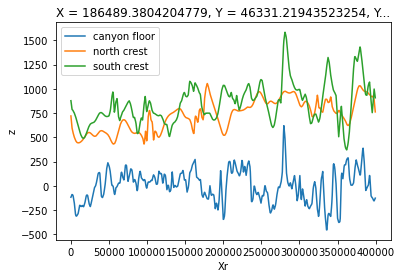

In [156]:

newds['z'].sel(Yr=3e4, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=10).plot(label='north crest')
newds['z'].isel(Yr=-10).plot(label='south crest')
newds.to_netcdf(input_path+"geocoords.nc")

plt.legend()

#plt.savefig("../../figures/BBTRE/config_canyon_along-channel-section-detrended.png", dpi=100., bbox_inches='tight')

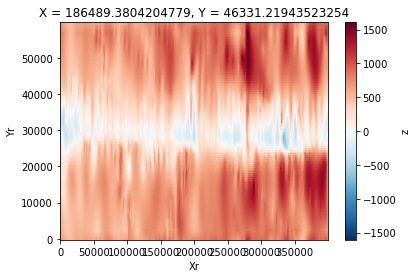

In [157]:
q = newds['z'].plot()

#### Stretched vertical grid

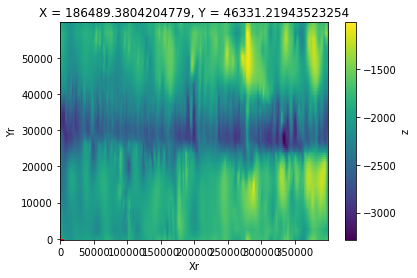

In [158]:
nz_vary = np.int(nz*nz_vary_frac)
dz = dz0 * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
dz[nz_vary:,:,:] = dz[nz_vary,0,0]*1.0275**np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
Hz = sum(dz[:,0,0])

x = np.arange(dx/2.0,Lx,dx)[np.newaxis,np.newaxis,:]*np.ones((nz,ny,nx))
y = np.arange(dy/2.0,Ly,dy)[np.newaxis,:,np.newaxis]*np.ones((nz,ny,nx))
z = (-Hz + np.cumsum(dz,axis=0) - dz/2.0)

plt.figure()
plt.plot(dz[:,0,0],z[:,0,0],"r-+")


Hbot = newds['z'] - (newds['z'].min().values) - (Hz - dz0)
Hbot.plot()

#### Initial conditions

In [159]:
gamma = (N**2)/(gravity*tAlpha)
gamma_eps = gamma*1.e-4

U = np.zeros((nz, ny, nx))
V = np.zeros((nz, ny, nx))

T = np.zeros((nz, ny, nx))
T += np.random.normal(size=(nz, ny, nx),scale=2.e-8)/(gravity*tAlpha) # Callies2018 initial perturbation

print("Temperature Lapse Rate is: "+np.str((N**2)/(gravity*tAlpha)))

Temperature Lapse Rate is: 0.0008613659531090722


#### Forcing

In [160]:
# generate 3D vertical eddy diffusivity field
K = np.zeros((nz,ny,nx))
for i in range(nx):
    for j in range(ny):
        K[:, j, i] = k0 + k1*np.exp(-(z[:,0,0] - Hbot[j,i].values)/d)
K[K>(k1+k0)] = k1+k0

### Tracers

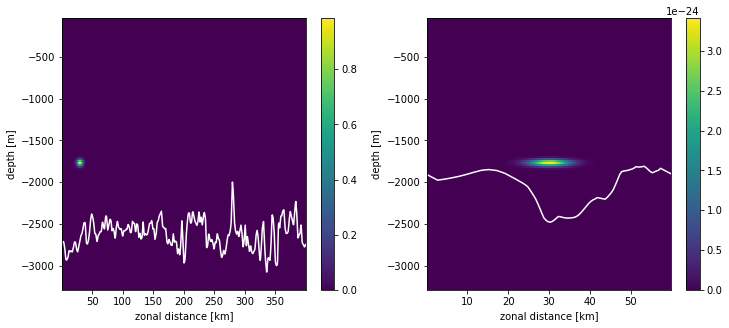

In [205]:
δz = 40.
δx = 0.5e4
δy = 0.5e4
x1 = 3.e4; x2 = x1;
y1 = 3.e4; y2 = y1;

z1 = (Hbot.sel(Xr = x1, Yr = y1, method='nearest') + 900.).values
z2 = (Hbot.sel(Xr = x2, Yr = y2, method='nearest') + 100).values

C1 = np.exp(- ((x - x1)/δx)**2 - ((y - y1)/δy)**2 - ((z - z1)/δz)**2)
C2 = np.exp(- ((x - x2)/δx)**2 - ((y - y2)/δy)**2 - ((z - z2)/δz)**2)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],C1[:,ny//2,:])
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.plot(x[0,0,:]*1e-3, Hbot[ny//2,:], "w-")

plt.subplot(1,2,2)
plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],C1[:,:,nx//6])
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.plot(y[0,:,0]*1e-3, Hbot[:,nx//6], "w-")

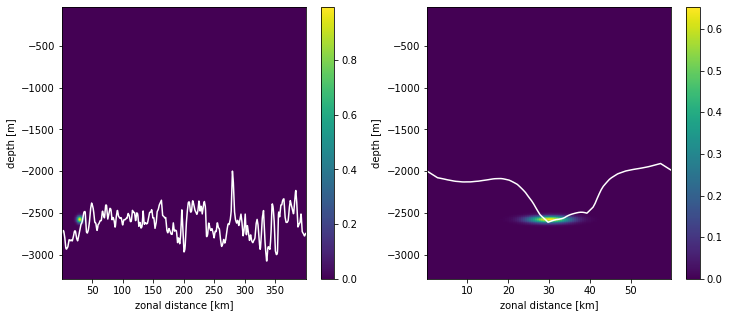

In [206]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],C2[:,ny//2,:])
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.plot(x[0,0,:]*1e-3, Hbot[ny//2,:], "w-")

plt.subplot(1,2,2)
plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],C2[:,:,nx//12])
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.plot(y[0,:,0]*1e-3, Hbot[:,nx//12], "w-")

## Configuration summary plot

In [ ]:
Hremoved = newds['z_slope']

Hoffset = Hremoved + (Hz-dz0)

fig = plt.figure(figsize=(16*0.8,8.75*0.8))
gs = fig.add_gridspec(3, 1)

f_ax1 = fig.add_subplot(gs[0, :])
q = ds['z'].plot(x='lon', y='lat', alpha=0.5)
q.set_clim([-5500, -2500])
q.colorbar.remove()
q = (newds['z']+Hremoved).plot(x='lon', y='lat')
q.set_clim([-5500, -2500])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, label=r"seafloor elevation [m]")
plt.plot(
    [newds['lon'].isel(Xr=0, Yr=0), newds['lon'].isel(Xr=0, Yr=-1), newds['lon'].isel(Xr=-1, Yr=-1), newds['lon'].isel(Xr=-1, Yr=0), newds['lon'].isel(Xr=0, Yr=0)],
    [newds['lat'].isel(Xr=0, Yr=0), newds['lat'].isel(Xr=0, Yr=-1), newds['lat'].isel(Xr=-1, Yr=-1), newds['lat'].isel(Xr=-1, Yr=0), newds['lat'].isel(Xr=0, Yr=0)],
    "k-"
)

X0 = newds['lon'].isel(Xr=0, Yr=0);
Xx = newds['lon'].isel(Xr=-1, Yr=0);
Xy = newds['lon'].isel(Xr=0, Yr=-1);
Y0 = newds['lat'].isel(Xr=0, Yr=0);
Yx = newds['lat'].isel(Xr=-1, Yr=0);
Yy = newds['lat'].isel(Xr=0, Yr=-1)
plt.arrow(-13, -21.75, (Xx-X0)*0.1, (Yx-Y0)*0.1, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.arrow(-13, -21.75, (Xy-X0)*0.67, (Yy-Y0)*0.67, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
Xa = -13; Ya = -21.75;
plt.annotate(s=r"$x$", xy=(Xa+0.45, Ya-0.05), fontsize=14)
plt.annotate(s=r"$y$", xy=(Xa-0.25, Ya+0.375), fontsize=14)
plt.title("")
plt.xlabel("longitude [degrees E]")
plt.ylabel("latitude [degrees N]")
plt.xticks(np.arange(-19, -11, 1))
plt.yticks(np.arange(-22, -20, 0.5))

q.set_clim([-5500, -2500])
plt.ylim([-22, -20.5])

nancol = (0.65,0.65,0.65)
f_ax1 = fig.add_subplot(gs[1:, :], facecolor=nancol)
q = plt.pcolor(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values,K[:,ny//2,:], norm=matplotlib.colors.LogNorm(vmin=5.e-5, vmax=2.e-3))
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar(q, pad=0.01, label=r"vertical diffusivity [m$^{2}$/s]")
plt.fill_between(x[0,0,:]*1e-3, Hremoved - 10, Hbot[ny//2,:]+Hoffset, facecolor=nancol)
plt.plot(x[0,0,:]*1e-3, Hremoved, "k--")
plt.contour(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values, C1[:,ny//2,:], levels=[0.37], colors="w", linewidths=2.5)
plt.contour(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values, C2[:,ny//2,:], levels=[0.37], colors="w", linewidths=2.5)

plt.plot(Hbot['Xr']*1e-3, (Hbot+Hoffset).isel(Yr=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='Yr'), color=nancol, lw=3.0)
plt.ylim(Hremoved.min(), np.max(z[:,0,:]+Hoffset.values))
plt.xlim([0, 400])

plt.annotate(s="Bottom Tracer Release", xy=(32, -4600), color="w", fontsize=14, weight="bold")
plt.annotate(s="Interior Tracer Release", xy=(5, -3350), color="w", fontsize=14, weight="bold")
plt.annotate(s="DoMORE sill", xy=(260, -3050), color="w", fontsize=14, weight="bold")
plt.tight_layout()

plt.savefig("../../figures/BBTRE/domain_configuration.png", dpi=100., bbox_inches='tight')

#### Write init files

In [123]:
# Reverse vertical axis so first index is at the surface and transpose axes
U = U[::-1,:,:]
V = V[::-1,:,:]
T = T[::-1,:,:]
K = K[::-1,:,:]
C1 = C1[::-1,:,:]
C2 = C2[::-1,:,:]
dz = dz[::-1,:1,:1]

# save input data as binary files
newFile = open(input_path+"U.init", "wb")
newFile.write(bytes(U.astype('>f8')))
newFile.close()

newFile = open(input_path+"V.init", "wb")
newFile.write(bytes(V.astype('>f8')))
newFile.close()

newFile = open(input_path+"T.init", "wb")
newFile.write(bytes(T.astype('>f8')))
newFile.close()

newFile = open(input_path+"kappa.init", "wb")
newFile.write(bytes(K.astype('>f8')))
newFile.close()

newFile = open(input_path+"cInterior.init", "wb")
newFile.write(bytes(C1.astype('>f8')))
newFile.close()

newFile = open(input_path+"cBottom.init", "wb")
newFile.write(bytes(C2.astype('>f8')))
newFile.close()

newFile = open(input_path+"topog.init", "wb")
newFile.write(bytes(Hbot[:,:].values.astype('>f8')))
newFile.close()

newFile = open(input_path+"delZ.init", "wb")
newFile.write(bytes(dz[:,0,0].astype('>f8')))
newFile.close()

In [124]:
import os
os.system(f"cp ./gendata_BBTRE.ipynb {input_path}");